### Uploading to S3

In [234]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

### Change tag to jobnames
tag = 'all-feat-no-scale'
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S-%f")[:-4]
job_name = f'{tag}-{timestamp}'

prefix='dengai'
raw_prefix = f'{prefix}/raw_data'
pprocess_prefix = f'{prefix}/{job_name}/pprocess_data'
model_prefix = f'{prefix}/{job_name}/models'
batch_transform_prefix = f'{prefix}/{job_name}/batch-transform'

In [235]:
if len(sagemaker_session.list_s3_files(bucket, raw_prefix))<5:
    ! wget -nc https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_features_train.csv -P ./data/input
    ! wget -nc https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_labels_train.csv -P ./data/input
    ! wget -nc https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_features_test.csv -P ./data/input
    ! wget -nc https://s3.amazonaws.com/drivendata-prod/data/44/public/submission_format.csv -P ./data/input  
    s3_uri = sagemaker_session.upload_data('./data/input', bucket, raw_prefix)
    print(f'Uploaded raw files to {s3_uri}')

In [236]:
from sagemaker.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor = ScriptProcessor(image_uri='964501460451.dkr.ecr.eu-central-1.amazonaws.com/sagemaker-containers:updated-sklearn_0.22.0-cpu-py3',
                                     role=role,
                                     instance_type='ml.m4.xlarge',
                                     instance_count=1,
                                     command = ["python3"], # default required using the same as in SKLearnProcessor
                                     volume_size_in_gb=30, # default required using the same as in SKLearnProcessor
                                    )

sklearn_processor.run(code='preprocessing.py',
                      job_name=f'{job_name}-preprocessing',
                      inputs=[
                          ProcessingInput(
                              source=f's3://{bucket}/{raw_prefix}',
                              input_name='input_data',
                              destination='/opt/ml/processing/input')
                      ],
                      outputs=[
                          ProcessingOutput(
                              source='/opt/ml/processing/output',
                              output_name='output_data',
                              destination=f's3://{bucket}/{pprocess_prefix}')                
                      ]
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()
output_config = preprocessing_job_description['ProcessingOutputConfig']

for output in output_config['Outputs']:
    if output['OutputName'] == 'output_data':
        preprocessed_data = output['S3Output']['S3Uri']


Job Name:  all-feat-no-scale-2020-04-09-15-05-55-09-preprocessing
Inputs:  [{'InputName': 'input_data', 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-964501460451/dengai/raw_data', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-964501460451/all-feat-no-scale-2020-04-09-15-05-55-09-preprocessing/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output_data', 'S3Output': {'S3Uri': 's3://sagemaker-eu-central-1-964501460451/dengai/all-feat-no-scale-2020-04-09-15-05-55-09/pprocess_data', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.......................Received arguments Namespace()
Reading inpu

In [237]:
train_path = f'{preprocessed_data}/train_pp.json'
test_path_sj = f'{preprocessed_data}/test_pp_sj.json'
test_path_iq = f'{preprocessed_data}/test_pp_iq.json'

### Creating training job

In [238]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
import csv

def fit_model(train_path, base_job_name, prediction_length, context_length):
    image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar') 
    s3_output_path_model = f's3://{bucket}/{model_prefix}'
    
    estimator = Estimator(sagemaker_session=sagemaker_session,
                            image_name=image_name,
                            role=role,
                            train_instance_count=1,
                            train_instance_type='ml.c4.xlarge',
                            output_path=s3_output_path_model,
                            base_job_name=base_job_name)
    
    hyperparameters_base = {
        "epochs": "100",
        "time_freq": 'W',
        "num_cells": "40",
        "num_layers": "2",
        "mini_batch_size": "128",
        "learning_rate": "0.003",
        "early_stopping_patience": "10",
        'prediction_length': prediction_length,
        'context_length': context_length}
    
    job_dict = {'jobname': job_name}
    job_dict.update(hyperparameters_base)
    with open('./models.hyperparameters.csv', 'a+', newline='') as f:
        w = csv.DictWriter(f, fieldnames=job_dict.keys())
        if not f.readline():
            w.writeheader()
        w.writerow(job_dict)
    
    data_channels = {"train": train_path}
    estimator.set_hyperparameters(**hyperparameters_base)
    estimator.fit(inputs=data_channels)
    return estimator

In [ ]:
estimator_sj = fit_model(train_path, f'{prefix}-deepar-{tag}-SJ', str(PREDICTION_LENGTH_SJ), str(PREDICTION_LENGTH_SJ))

In [240]:
estimator_iq = fit_model(train_path, f'{prefix}-deepar-{tag}-IQ', str(PREDICTION_LENGTH_IQ), str(PREDICTION_LENGTH_SJ))

2020-04-09 15:37:30 Starting - Starting the training job...
2020-04-09 15:37:31 Starting - Launching requested ML instances......
2020-04-09 15:38:57 Starting - Preparing the instances for training...
2020-04-09 15:39:30 Downloading - Downloading input data...
2020-04-09 15:39:36 Training - Downloading the training image...
2020-04-09 15:40:19 Training - Training image download completed. Training in progress.Arguments: train
[04/09/2020 15:40:21 INFO 140468212922176] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'au

## Testing our model

### If we want to skip training and reuse a previously trained model

In [ ]:
from sagemaker.model import Model

def get_model(model_file):
    model_s3_path = f's3://{bucket}/{model_file}'
    model = Model(model_data=model_s3_path,
              image=image_name,
             role=role)
    return model

sagemaker_session.list_s3_files(bucket, prefix)

### Batch transform

In [243]:
import os

def batch_transform(estimator, data_path, base_job_name):
    s3_batch_output_path = f's3://{bucket}/{batch_transform_prefix}'
    transformer = estimator.transformer(instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    strategy='SingleRecord',
                                    assemble_with='Line',
                                    output_path=s3_batch_output_path)
    transformer.transform(data=data_path,
                          data_type='S3Prefix',
                          content_type=None,
                          split_type='Line',
                          wait=True,
                          logs=True)
    
    file_name = os.path.basename(data_path)
    output_path = f'{s3_batch_output_path}/{file_name}.out'
    return output_path

predictions_sj_path = batch_transform(estimator_sj, test_path_sj,'SJ')
predictions_iq_path = batch_transform(estimator_iq, test_path_iq,'IQ')

.........................Arguments: serve
No handlers could be found for logger "root"
[04/09/2020 16:00:20 INFO 140248838670144] Estimated memory required per model 124MB.
[04/09/2020 16:00:20 INFO 140248838670144] Estimated available memory 14991MB.
[04/09/2020 16:00:20 INFO 140248838670144] Estimated maximum number of workers for the available memory is 120.
[04/09/2020 16:00:20 INFO 140248838670144] Using 4 workers
[04/09/2020 16:00:20 INFO 140248838670144] loading entry points
[04/09/2020 16:00:20 INFO 140248838670144] Prediction endpoint operating in batch mode
[04/09/2020 16:00:20 INFO 140248838670144] loaded request iterator application/jsonlines
[04/09/2020 16:00:20 INFO 140248838670144] loaded response encoder application/jsonlines
[04/09/2020 16:00:20 INFO 140248838670144] loaded model class model
[04/09/2020 16:00:20 WARNING 140248838670144] Requesting context without setting the requested num of gpus. Using 'auto'
[04/09/2020 16:00:20 INFO 140248838670144] nvidia-smi took:

### Get results and plot

In [244]:
# helper function to decode JSON prediction
def unjson_prediction(predictions):
    '''Accepts a JSON prediction and returns a list of quantiles for prediction.
    '''
    prediction_data = json.loads(predictions)
    predictions_quantiles = pd.DataFrame(prediction_data['quantiles'])
    return predictions_quantiles

In [245]:
predictions_sj = unjson_prediction(sagemaker.s3.S3Downloader.read_file(predictions_sj_path))
predictions_iq = unjson_prediction(sagemaker.s3.S3Downloader.read_file(predictions_iq_path))

In [267]:
import matplotlib.pyplot as plt

# display the prediction median against the actual data
def display_quantiles(prediction, previous_submission_path=None):
    plt.figure(figsize=(12,6))
    
    # get the quantile values at 10 and 90%
    p10 = prediction['0.1']
    p90 = prediction['0.9']
    
    # fill the 80% confidence interval
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    
    # plot the median prediction line
    prediction['0.5'].plot(label='prediction median')
    city='iq'
    if len(prediction['0.5'])==260:
        city='sj'
    
    # plot previous submission
    if previous_submission_path:
        try:
            prev = pd.read_csv(previous_submission_path)
            pd.Series(tmp[tmp.city==city].total_cases.tolist()).plot(label='prv')
        except FileNotFoundError as err:
            print(err)
        
    plt.legend()
    plt.show()

In [264]:
previous_submissions_to_plot = './submissions/submission_2020-04-08_13-30-20_313455.csv'

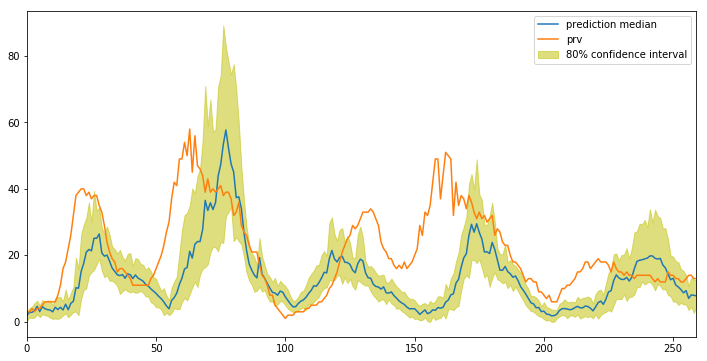

In [271]:
display_quantiles(predictions_sj, previous_submissions_to_plot)

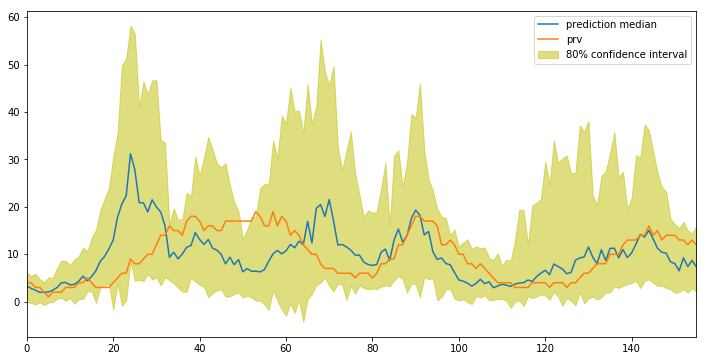

In [272]:
display_quantiles(predictions_iq, previous_submissions_to_plot)

## Creating output CSV for submission

In [275]:
def create_submission(predictions_sj, predictions_iq, template_file='./data/input/submission_format.csv', output_dir='./submissions'):
    submission = pd.read_csv(template_file)
    submission.loc[submission.city=='iq', 'total_cases'] = predictions_iq['0.5'].tolist()
    submission.loc[submission.city=='sj', 'total_cases'] = predictions_sj['0.5'].tolist()
    submission['total_cases'] = submission['total_cases'].round().astype(int)
    submission.to_csv(f'{output_dir}/submission_{job_name}.csv', index=False)

In [276]:
create_submission(predictions_sj, predictions_iq)